# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_h23.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

CPI  CPI Tradable  CPI Non-Tradable  CPI Core  CPI Non-Core  \
Fecha                                                                          
2023-08-01  0.182324      0.263821          0.147377  0.308731     -0.071459   
2023-09-01  0.133933      0.237390          0.089467  0.281829     -0.163217   
2023-10-01  0.085365      0.210974          0.031289  0.254555     -0.254697   
2023-11-01  0.036736      0.184472         -0.026935  0.226933     -0.345597   
2023-12-01 -0.011845      0.157822         -0.085018  0.198984     -0.435639   

            CPI Food and Energy  CPI Excluding Food and Energy  \
Fecha                                                            
2023-08-01             0.175741                       0.189515   
2023-09-01             0.099223                       0.165369   
2023-10-01             0.022078                       0.141472   
2023-11-01            -0.055512                       0.117886   
2023-12-01            -0.133358                       0.094639   

            CPI Food and Beverages  CPI Excluding Food and Beverages  \
Fecha                                                                  
2023-08-01                0.263738                          0.125240   
2023-09-01                0.179682                          0.102272   
2023-10-01                0.094521                          0.079821   
2023-11-01                0.008508                          0.057913   
2023-12-01               -0.078087                          0.036539   

            CPI Core Excluding Food and Beverages  CPI Imported  \
Fecha                                                             
2023-08-01                               0.215058     -0.170008   
2023-09-01                               0.195769     -0.206148   
2023-10-01                               0.176261     -0.240150   
2023-11-01                               0.156596     -0.272242   
2023-12-01                               0.136819     -0.302719   

            Wholesale Price Index  Reserve Requirement Rate  \
Fecha                                                         
2023-08-01              -0.104763                  5.129333   
2023-09-01              -0.125837                  5.262712   
2023-10-01              -0.144366                  5.270346   
2023-11-01              -0.160344                  5.629236   
2023-12-01              -0.173843                  5.858670   

            Monetary Policy Rate  \
Fecha                              
2023-08-01                  7.75   
2023-09-01                  7.50   
2023-10-01                  7.25   
2023-11-01                  7.00   
2023-12-01                  6.75   

            Circulating Currency Seasonally Adjusted (mill S/)  \
Fecha                                                            
2023-08-01                                          -0.002583    
2023-09-01                                           0.002269    
2023-10-01                                           0.006678    
2023-11-01                                          -0.002775    
2023-12-01                                          -0.013317    

            Net International Reserves (mill $)  Real Minimum Wage (Index)  
Fecha                                                                       
2023-08-01                            -0.019404                  -0.003747  
2023-09-01                            -0.008615                  -0.000164  
2023-10-01                            -0.001206                   0.003235  
2023-11-01                             0.008482                   0.000000  
2023-12-01                            -0.010011                   0.000000

In [4]:
df_lags = pd.read_csv('../../../input/df_lags_h23.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

CPI  CPI Tradable_lag_1  CPI Tradable_lag_2  \
Fecha                                                          
2023-08-01  0.182324            0.290249            0.316561   
2023-09-01  0.133933            0.263821            0.290249   
2023-10-01  0.085365            0.237390            0.263821   
2023-11-01  0.036736            0.210974            0.237390   
2023-12-01 -0.011845            0.184472            0.210974   

            CPI Non-Tradable_lag_1  CPI Non-Tradable_lag_2  CPI Core_lag_1  \
Fecha                                                                        
2023-08-01                0.204813                0.261591        0.335223   
2023-09-01                0.147377                0.204813        0.308731   
2023-10-01                0.089467                0.147377        0.281829   
2023-11-01                0.031289                0.089467        0.254555   
2023-12-01               -0.026935                0.031289        0.226933   

            CPI Core_lag_2  CPI Non-Core_lag_1  CPI Non-Core_lag_2  \
Fecha                                                                
2023-08-01        0.361269            0.020204            0.111347   
2023-09-01        0.335223           -0.071459            0.020204   
2023-10-01        0.308731           -0.163217           -0.071459   
2023-11-01        0.281829           -0.254697           -0.163217   
2023-12-01        0.254555           -0.345597           -0.254697   

            CPI Food and Energy_lag_1  ...  Reserve Requirement Rate_lag_1  \
Fecha                                  ...                                   
2023-08-01                   0.251427  ...                        5.588473   
2023-09-01                   0.175741  ...                        5.129333   
2023-10-01                   0.099223  ...                        5.262712   
2023-11-01                   0.022078  ...                        5.270346   
2023-12-01                  -0.055512  ...                        5.629236   

            Reserve Requirement Rate_lag_2  Monetary Policy Rate_lag_1  \
Fecha                                                                    
2023-08-01                        5.974649                        7.75   
2023-09-01                        5.588473                        7.75   
2023-10-01                        5.129333                        7.50   
2023-11-01                        5.262712                        7.25   
2023-12-01                        5.270346                        7.00   

            Monetary Policy Rate_lag_2  \
Fecha                                    
2023-08-01                        7.75   
2023-09-01                        7.75   
2023-10-01                        7.75   
2023-11-01                        7.50   
2023-12-01                        7.25   

            Circulating Currency Seasonally Adjusted (mill S/)_lag_1  \
Fecha                                                                  
2023-08-01                                          -0.017679          
2023-09-01                                          -0.002583          
2023-10-01                                           0.002269          
2023-11-01                                           0.006678          
2023-12-01                                          -0.002775          

            Circulating Currency Seasonally Adjusted (mill S/)_lag_2  \
Fecha                                                                  
2023-08-01                                          -0.011038          
2023-09-01                                          -0.017679          
2023-10-01                                          -0.002583          
2023-11-01                                           0.002269          
2023-12-01                                           0.006678          

            Net International Reserves (mill $)_lag_1  \
Fecha                                                   
2023-08-01                                   

## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

In [5]:
def get_RMSE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the RMSE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing RMSE for each row.
    '''
    RMSE = []

    for index, row in results.iterrows():
        sqr_err = (row['Actual'] - row['Predicted']) ** 2
        rmse = np.sqrt(sqr_err)
        RMSE.append(rmse)

    return RMSE

def get_MAPE(results):
    '''
    Objective:
        This function receives a DataFrame with both Actual and Predicted values and calculates the MAPE
        for each row.
        
    Input:
        results (DataFrame): DataFrame with 'Actual' and 'Predicted' columns.
        
    Output:
        A list containing MAPE for each row.
    '''
    MAPE = []

    for index, row in results.iterrows():
        per_err = abs((row['Actual'] - row['Predicted']) / row['Actual'])
        MAPE.append(per_err)

    return MAPE



### 3.1.1 Random Walk (RW)

In [5]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2023-01-01']
test_set  = df_CPI[df_CPI.index >= '2023-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-h, 0] + train_set.std()[0]

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

Horizon  Prediction
Fecha                          
2023-01-01        1    0.706050
2023-02-01        2    0.747616
2023-03-01        3    0.781155
2023-04-01        4    0.804524
2023-05-01        5    0.817302
2023-06-01        6    0.822075
2023-07-01        7    0.822893
2023-08-01        8    0.823073
2023-09-01        9    0.823981
2023-10-01       10    0.825082
2023-11-01       11    0.823065
2023-12-01       12    0.813394

In [6]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

Horizon  Predicted    Actual
Fecha                                   
2023-01-01        1   0.706050  0.514333
2023-02-01        2   0.747616  0.464964
2023-03-01        3   0.781155  0.417904
2023-04-01        4   0.804524  0.371486
2023-05-01        5   0.817302  0.324949
2023-06-01        6   0.822075  0.277964
2023-07-01        7   0.822893  0.230389
2023-08-01        8   0.823073  0.182324
2023-09-01        9   0.823981  0.133933
2023-10-01       10   0.825082  0.085365
2023-11-01       11   0.823065  0.036736
2023-12-01       12   0.813394 -0.011845

In [7]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

RMSE_RW   MAPE_RW
1   0.191717  0.372750
2   0.241503  0.490326
3   0.287865  0.616624
4   0.330197  0.753891
5   0.368384  0.906147
6   0.403028  1.081372
7   0.435177  1.294282
8   0.465861  1.571788
9   0.495802  1.969608
10  0.525315  2.639184
11  0.554147  4.345146
12  0.581585  9.788783

### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [8]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2023-01-01']
test_set  = df_CPI[df_CPI.index >= '2023-01-01']

In [9]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

Predicted    Actual
Fecha                          
2023-01-01   0.514394  0.514333
2023-02-01   0.467084  0.464964
2023-03-01   0.419718  0.417904
2023-04-01   0.371546  0.371486
2023-05-01   0.322593  0.324949
2023-06-01   0.272635  0.277964
2023-07-01   0.221956  0.230389
2023-08-01   0.171193  0.182324
2023-09-01   0.122049  0.133933
2023-10-01   0.076559  0.085365
2023-11-01   0.036120  0.036736
2023-12-01   0.001177 -0.011845

In [10]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

RMSE_ARIMA  MAPE_ARIMA
1     0.000061    0.000119
2     0.001500    0.002339
3     0.001611    0.003006
4     0.001396    0.002295
5     0.001633    0.003286
6     0.002637    0.005933
7     0.004015    0.010315
8     0.005440    0.016657
9     0.006481    0.024665
10    0.006749    0.032514
11    0.006438    0.031083
12    0.007220    0.120104

### 3.1.3 Vector autoregression (VAR)

In [11]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2023-01-01']
test_set  = df[df.index >= '2023-01-01']

In [12]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [13]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

Predicted    Actual
Fecha                          
2023-01-01  -0.056664  0.514333
2023-02-01  -0.097878  0.464964
2023-03-01  -0.136047  0.417904
2023-04-01  -0.171129  0.371486
2023-05-01  -0.203022  0.324949
2023-06-01  -0.231636  0.277964
2023-07-01  -0.256842  0.230389
2023-08-01  -0.278505  0.182324
2023-09-01  -0.296512  0.133933
2023-10-01  -0.310776  0.085365
2023-11-01  -0.321238  0.036736
2023-12-01  -0.327873 -0.011845

In [16]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

RMSE_VAR  MAPE_VAR
1   0.570997  1.110170
2   0.566934  1.160339
3   0.562640  1.215407
4   0.557701  1.276721
5   0.551883  1.346333
6   0.545063  1.427499
7   0.537183  1.525687
8   0.528243  1.650917
9   0.518288  1.824578
10  0.507399  2.106177
11  0.495679  2.800568
12  0.483266  4.790506

<Axes: >

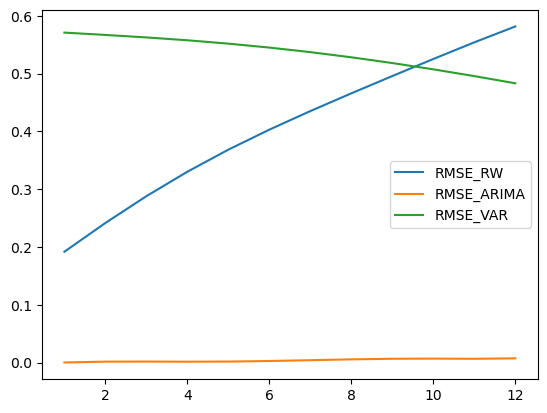

In [17]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [20]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [21]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
print(y_pred)

Fecha
2023-01-01    0.516820
2023-02-01    0.468058
2023-03-01    0.421816
2023-04-01    0.375758
2023-05-01    0.329873
2023-06-01    0.283961
2023-07-01    0.236762
2023-08-01    0.189551
2023-09-01    0.140733
2023-10-01    0.091800
2023-11-01    0.042855
2023-12-01   -0.005812
dtype: float64


In [25]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

Predicted    Actual
Fecha                          
2023-01-01   0.516820  0.514333
2023-02-01   0.468058  0.464964
2023-03-01   0.421816  0.417904
2023-04-01   0.375758  0.371486
2023-05-01   0.329873  0.324949
2023-06-01   0.283961  0.277964
2023-07-01   0.236762  0.230389
2023-08-01   0.189551  0.182324
2023-09-01   0.140733  0.133933
2023-10-01   0.091800  0.085365
2023-11-01   0.042855  0.036736
2023-12-01  -0.005812 -0.011845

In [26]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

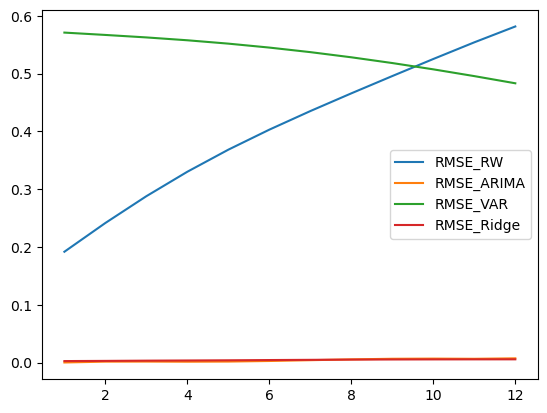

In [27]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [35]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [36]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)


In [37]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

Predicted    Actual
Fecha                          
2023-01-01   0.512741  0.514333
2023-02-01   0.464762  0.464964
2023-03-01   0.418527  0.417904
2023-04-01   0.373759  0.371486
2023-05-01   0.328504  0.324949
2023-06-01   0.282526  0.277964
2023-07-01   0.236379  0.230389
2023-08-01   0.189776  0.182324
2023-09-01   0.142129  0.133933
2023-10-01   0.094346  0.085365
2023-11-01   0.046344  0.036736
2023-12-01  -0.001578 -0.011845

In [38]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

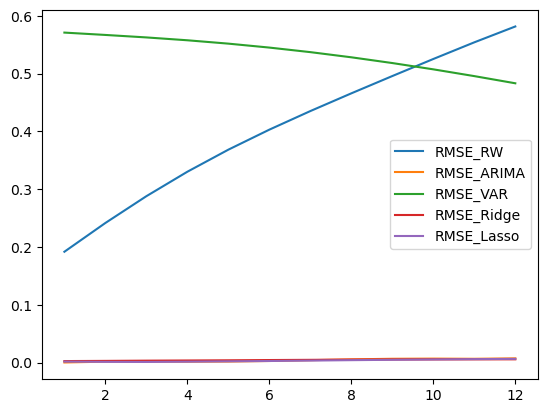

In [39]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [40]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = [5, 6, 10, 12, 15]

max_depth = [10, 20, 30, 50]

grid_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [41]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [42]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results

Predicted    Actual
Fecha                          
2023-01-01   0.501091  0.514333
2023-02-01   0.458185  0.464964
2023-03-01   0.402501  0.417904
2023-04-01   0.353090  0.371486
2023-05-01   0.325218  0.324949
2023-06-01   0.294878  0.277964
2023-07-01   0.220976  0.230389
2023-08-01   0.209481  0.182324
2023-09-01   0.123168  0.133933
2023-10-01   0.089067  0.085365
2023-11-01   0.069764  0.036736
2023-12-01   0.069981 -0.011845

In [43]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

<Axes: >

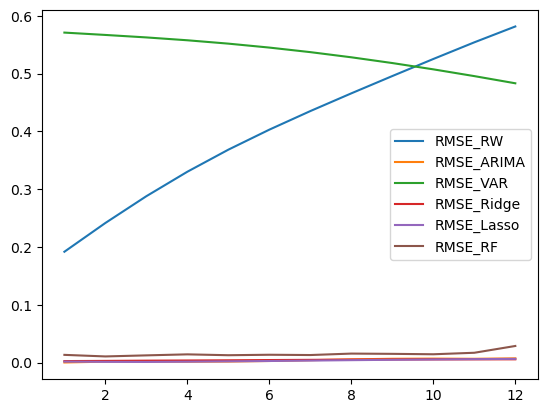

In [44]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1).plot()

<Axes: >

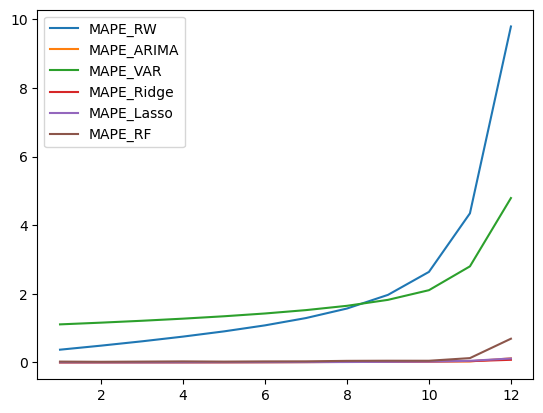

In [45]:
pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1).plot()

### Previous code

In [48]:
models = {
    
    'Lasso'        : { 'model'      : Lasso( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Ridge'        : { 'model'      : Ridge( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ] } },
    
    'Elastic Net'  : { 'model'      : ElasticNet( random_state = 2023 ),
                       'grid_params': { 'alpha': [ 0.0001, 0.001, 0.01, 0.1 ], 'l1_ratio': np.arange(0.0, 1.0, 0.1) } },
    
    'Random Forest': { 'model'      : RandomForestRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } },
    
    'Gradient Boosting': { 'model'  : XGBRegressor( random_state = 2023, n_jobs = -1 ),
                       'grid_params': { 'n_estimators': [ 50, 100, 150, 200 ], 'max_depth': [10, 20, 30, 50] } }
    
        }

In [49]:
# We define our target variable, as well as our train and test set
# ==============================================================================
steps = 12
target = 'CPI'
train_set = df_lags[:-steps]
test_set  = df_lags[-steps:]

In [50]:
y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

In [51]:
pred_vars = X_train.columns.to_list()

In [56]:
print(f"Training and tuning models...")

results = {
    'Model': [],
    'R2_train': [],
    'R2_test': [],
    'MAE_train': [],
    'MAE_test': [],
    'MAPE_train': [],
    'MAPE_test': [],
    'MSE_train': [],
    'MSE_test': [],
    'RMSE_train': [],
    'RMSE_test': [],
    'Grid_Search_Params': []
}

for model_name, model_params in models.items():
    print(f"Processing model: {model_name}")

    if 'model' in model_params:
        model = model_params['model']
    else:
        raise ValueError(f'Model is not defined for {model_name}')

    if 'grid_params' in model_params:
        grid_params = model_params['grid_params']
    else:
        grid_params = None

    best_params = None

    grid_search = GridSearchCV(model, grid_params, cv=tscv)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    if hasattr( best_model, 'feature_importances_' ):

        feature_importances = best_model.feature_importances_
        vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
        vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist__{ model_name }.xlsx' )

    elif hasattr( best_model, 'coef_' ):

        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist_{ model_name }.xlsx' )
    else:
        best_model = model.fit(X_train, y_train)
        coefficients = best_model.coef_[ 0 ]
        vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
        vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
        vars_df.to_excel( f'../../../output/3_Regression/varlist_{ model_name }.xlsx' )

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        results = pd.concat([y_pred_test, y_test],axis=1)
        
        RMSE_test, MAPE_test = get_metrics(results, f'{model_name}')

        best_model_params = {
            'Model': model_name,
            'MAPE_test': MAPE_test,
            'RMSE_test': RMSE_test,
            'Grid_Search_Params': best_params
        }

        results['Model'].append(best_model_params['Model'])
        results['MAPE_test'].append(best_model_params['MAPE_test'])
        results['RMSE_test'].append(best_model_params['RMSE_test'])
        results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
        
print('Done')

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE_test', ascending=True)


Training and tuning models...
Processing model: Lasso
Processing model: Ridge
Processing model: Elastic Net
Processing model: Random Forest
Processing model: Gradient Boosting
Done


In [33]:
# forecaster = ForecasterAutoregMultiVariate(
#                  regressor = RandomForestRegressor(random_state=42),
#                  lags      = 2, # This value will be replaced in the grid search,
#     level = target,
#     steps = 2
#              )

# forecaster.fit()

# # Candidate values for lags
# lags_grid = [10, 20]

# # Candidate values for regressor's hyperparameters
# param_grid = {
#     'n_estimators': [100, 500],
#     'max_depth': [3, 5, 10]
# }

# results_grid = grid_search_forecaster(
#                    forecaster         = forecaster,
#                    y                  = test_set[target],
#                    level              = target,
#                    steps              = 2,
#                    param_grid         = param_grid,
#                    lags_grid          = lags_grid,
#                    steps              = steps,
#                    refit              = False,
#                    metric             = 'mean_squared_error',
#                    initial_train_size = 11,
#                    fixed_train_size   = False,
#                    return_best        = True,
#                    n_jobs             = 'auto',
#                    verbose            = False
#                )

In [34]:
# def test_models_regression(models, data, pred_vars, target_var ):
#     """
#     Evalúa modelos de regresión utilizando validación cruzada en series temporales.

#     Parámetros:
#     - modelos: Diccionario de modelos de regresión para evaluar.
#     - datos: DataFrame que contiene el conjunto de datos.
#     - variables_predictoras: Lista de nombres de variables predictoras.
#     - variable_objetivo: Nombre de la variable objetivo.

#     Retorna:
#     DataFrame: Resultados de la evaluación del modelo.
#     """       
#     results = {
#         'Model': [],
#         'R2_train': [],
#         'R2_test': [],
#         'MAE_train': [],
#         'MAE_test': [],
#         'MAPE_train': [],
#         'MAPE_test': [],
#         'MSE_train': [],
#         'MSE_test': [],
#         'RMSE_train': [],
#         'RMSE_test': [],
#         'Grid_Search_Params': []
#     }
    
#     X = data[pred_vars]
#     y = data[target_var]
    
#     cv = TimeSeriesSplit(n_splits=5)
    
#     print(f"Entrenando y evaluando modelos...")
    
#     for model_name, model_params in models.items():
#         print(f"Procesando el modelo: {model_name}")
        
#         if 'model' in model_params:
#             model = model_params['model']
#         else:
#             raise ValueError(f'Model is not defined for {model_name}')
        
#         if 'grid_params' in model_params:
#             grid_params = model_params['grid_params']
#         else:
#             grid_params = None
        
#         best_params = None
        
#         for ii, (tr, tt) in enumerate(cv.split(X, y)):
#             X_train, X_test = X.iloc[tr], X.iloc[tt]
#             y_train, y_test = y.iloc[tr], y.iloc[tt]
            
#             if ii == (cv.n_splits - 1):
            
#                 if grid_params is not None:
#                     grid_search = GridSearchCV(model, grid_params, cv=cv)
#                     grid_search.fit(X_train, y_train)
#                     best_model = grid_search.best_estimator_
#                     best_params = grid_search.best_params_

#                     if hasattr( best_model, 'feature_importances_' ):

#                         feature_importances = best_model.feature_importances_
#                         vars_df             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
#                         vars_df             = vars_df.reindex( vars_df[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist__{ model_name }.xlsx' )

#                     elif hasattr( best_model, 'coef_' ):

#                         coefficients = best_model.coef_[ 0 ]
#                         vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                         vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                         vars_df.to_excel( f'varlist_{ model_name }.xlsx' )
#                 else:
#                     best_model = model.fit(X_train, y_train)
#                     coefficients = best_model.coef_[ 0 ]
#                     vars_df      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
#                     vars_df      = vars_df.reindex( vars_df[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
#                     vars_df.to_excel( f'varlist_{ model_name }.xlsx' )

#                 y_pred_train = best_model.predict(X_train)
#                 y_pred_test = best_model.predict(X_test)

#                 best_model_params = {
#                     'Model': model_name,
#                     'Grid_Search_Params': best_params
#                 }

#         results['Model'].append(best_model_params['Model'])
#         results['Grid_Search_Params'].append(best_model_params['Grid_Search_Params'])
    
#     results_df = pd.DataFrame(results)
#     results_df = results_df.sort_values(by='RMSE_test', ascending=True)

#     return results_df